#**Ensemble_models**

Purpose:
- Train LightGBM and XGBoost models on safe FE dataset.
- Evaluate performance with time-based splits.
- Compare with LSTM forecasts.
- Explore hybrid ensemble methods (simple averaging, weighted).
- Save results under: `sandbox/models_ensemble/`.


#Cell 1 – Imports & Paths


In [7]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
PROJ = Path("/content/drive/MyDrive/player_value_prediction_project")
SAFE_FE = PROJ / "data" / "processed" / "master" / "sandbox" / "final_training_master_fe_safe.csv"
ENSEMBLE_DIR = PROJ / "data" / "processed" / "master" / "sandbox" / "models_ensemble"
ENSEMBLE_DIR.mkdir(parents=True, exist_ok=True)

print("Safe FE dataset:", SAFE_FE)
print("Ensemble outputs:", ENSEMBLE_DIR)


Safe FE dataset: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/final_training_master_fe_safe.csv
Ensemble outputs: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble


#Cell 2 – Load dataset + sanity check
This cell loads the safe FE dataset and checks shape, key columns, and missingness.

In [8]:
# Cell 2 – Load dataset + sanity check

# Load safe FE dataset
df = pd.read_csv(SAFE_FE, low_memory=False)
print("Loaded shape:", df.shape)

# Preview first rows
display(df.head(3))

# Check presence of key columns
expected_cols = ['player_id', 'season', 'target_log1p']
for col in expected_cols:
    print(f"{col} present?:", col in df.columns)

# Quick null percentage check
nulls = df.isna().mean().sort_values(ascending=False).head(15) * 100
print("\nTop 15 features by % missing:")
display(nulls)


Loaded shape: (87223, 176)


,season,name,age_at_season_start,position,sub_position,played_any,appearances_count,total_minutes,minutes_per_appearance,goals,...,goals_per90_scaled,assists_per90_scaled,goals_per_min_scaled,sb_xg_scaled,sb_shots_scaled,sb_passes_scaled,reddit_mean_compound_scaled,num_injuries_scaled,transfers_sum_fee_scaled,days_since_last_transfer_scaled
0,2012,Miroslav Klose,34.0,Attack,Centre-Forward,1,36,2585,71.805556,16,...,0.768854,0.020280,0.768854,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545
1,2013,Miroslav Klose,35.0,Attack,Centre-Forward,1,29,2220,76.551724,8,...,0.356620,0.220335,0.356620,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545
2,2014,Miroslav Klose,36.0,Attack,Centre-Forward,1,40,2289,57.225000,16,...,0.896447,0.528119,0.896447,-0.032374,-0.040526,-0.049753,-0.018729,-0.059164,-0.146907,-0.361545


player_id present?: False
season present?: True
target_log1p present?: True

Top 15 features by % missing:


,0
reddit_subreddits_covered,99.855543
avg_rating_drop,99.628538
mean_rating_after,99.606755
mean_rating_before,99.568921
last_transfer_date,76.724029
target_log1p_lag1_diff,29.452094
target_log1p_lag1,29.452094
appearances_count_lag1,29.452094
total_minutes_lag1_diff,29.452094
goals_lag1_diff,29.452094


### Cell 3 – Train-test split (time-based) + feature selection

We prepare the dataset for ensemble models:

- **Target:** `target_log1p` (log-transformed player value).
- **Drop columns:** identifiers (`season`, `name`, `row_id`) and target-related (`target_*`, `target_eur`, `target_choice`).
- **Features:** all remaining numeric and categorical engineered columns.
- **Split rule:**
  - Train = all seasons **≤ 2022**  
  - Test = seasons **2023–2024**  

This ensures no data leakage across time, keeping evaluation realistic for future seasons.


## 3.1 Create row_id and drop obvious leakage columns  

- Build a unique `row_id` = season + player name (for safe indexing).  
- Drop columns that could leak future info or identifiers.


In [9]:
#Cell 3.1 - Create row_id, drop leakage columns
df['row_id'] = df['season'].astype(str) + "_" + df['name'].astype(str)


## 3.2 Train/test split (time-based)  

Split data by season:  
- Train = seasons ≤ 2021  
- Test = seasons ≥ 2022


In [10]:
# Cell 3.2 – Train-test split (time-based) + feature selection

# Target
target_col = "target_log1p"

# Drop non-feature columns
drop_cols = [
    "name", "season", "row_id",
    target_col, "target_eur", "target_choice"
]
feature_cols = [c for c in df.columns if c not in drop_cols]

print("Total features available for modeling:", len(feature_cols))

# Train/test split by season
cutoff_year = 2022
train_df = df[df["season"] <= cutoff_year].copy()
test_df  = df[df["season"] > cutoff_year].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# X, y
X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test   = test_df[feature_cols], test_df[target_col]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Total features available for modeling: 171
Train shape: (74236, 177)
Test shape: (12987, 177)
X_train: (74236, 171) y_train: (74236,)
X_test: (12987, 171) y_test: (12987,)


## 3.3 Encode categorical features  

Encode `position`, `sub_position`, `foot`, `age_bucket` as integers.  
Keep only numeric/bool features for modeling.


In [11]:
# Cell 3.3 — Encode categorical features (cleaned & fixed)

from sklearn.preprocessing import LabelEncoder

# Drop raw date/object columns that aren’t meaningful for modeling
drop_obj_cols = [
    'reddit_subreddits_covered',
    'last_transfer_date', 'first_match_date', 'last_match_date',
    'first_date', 'last_date', 'date_of_birth', 'season_start_date',
    'name_norm'
]

df_enc = df.drop(columns=[c for c in drop_obj_cols if c in df.columns])

# Encode actual categorical columns
cat_cols = [c for c in ['position', 'sub_position', 'foot', 'age_bucket'] if c in df_enc.columns]
print("Categorical columns to encode:", cat_cols)

for c in cat_cols:
    le = LabelEncoder()
    df_enc[c] = le.fit_transform(df_enc[c].astype(str))

print("\nEncoded dataframe dtypes:")
print(df_enc.dtypes.value_counts())

# Recreate X, y
X = df_enc.drop(columns=[target_col, 'row_id'])
y = df_enc[target_col]

# Redo train/test split (time-based, consistent with earlier)
train_mask = df_enc['season'] <= 2021
test_mask = df_enc['season'] > 2021

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("\nShapes after encoding & split:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Quick peek at encoded features
print("\nSample encoded rows (head):")
print(X_train.head(3)[cat_cols])


Categorical columns to encode: ['position', 'sub_position', 'foot', 'age_bucket']

Encoded dataframe dtypes:
float64    102
int64       50
bool        13
object       3
Name: count, dtype: int64

Shapes after encoding & split:
X_train: (67138, 166) y_train: (67138,)
X_test: (20085, 166) y_test: (20085,)

Sample encoded rows (head):
   position  sub_position  foot  age_bucket
0         0             3     3           5
1         0             3     3           5
2         0             3     3           5


## 3.4 Final cleanup  

Drop leftover object columns (`name`, `target_choice`, etc.)  
Confirm all features are numeric or boolean before modeling.


In [12]:
# Cell 3.4 — Drop leftover object columns

obj_cols_left = X_train.select_dtypes(include=['object']).columns.tolist()
print("Dropping leftover object columns:", obj_cols_left)

X_train = X_train.drop(columns=obj_cols_left)
X_test = X_test.drop(columns=obj_cols_left)

print("Final dtypes after cleanup:", X_train.dtypes.value_counts())
print("Final train shape:", X_train.shape, "test shape:", X_test.shape)


Dropping leftover object columns: ['name', 'target_choice']
Final dtypes after cleanup: float64    101
int64       50
bool        13
Name: count, dtype: int64
Final train shape: (67138, 164) test shape: (20085, 164)


## 4.1 Train baseline LightGBM model  

Train LightGBM on safe dataset:  
- Evaluate RMSE & MAE on test set  
- Extract feature importance


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.0185236	valid_1's rmse: 0.0188335
[200]	training's rmse: 0.00170216	valid_1's rmse: 0.0106587
[300]	training's rmse: 0.00149923	valid_1's rmse: 0.0105758
Early stopping, best iteration is:
[295]	training's rmse: 0.00151092	valid_1's rmse: 0.0105451
Baseline LightGBM RMSE: 0.0105, MAE: 0.0003
Saved feature importance to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models/lgbm_feature_importance.csv


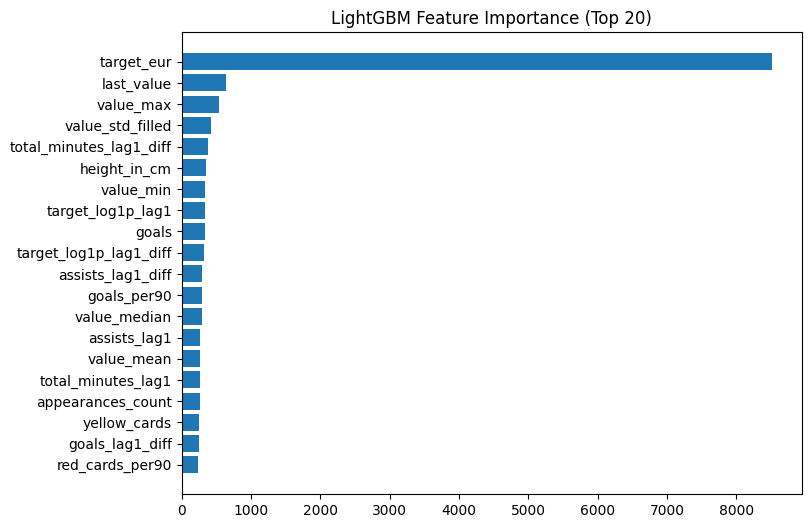

In [13]:
# Cell 4.1 — LightGBM baseline training

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Params
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train with early stopping
bst = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

# Predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"Baseline LightGBM RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Feature importance
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': bst.feature_importance()
}).sort_values('importance', ascending=False)

# Define model dir inside sandbox
from pathlib import Path

MODEL_DIR = Path("/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save feature importance
fi.to_csv(MODEL_DIR / "lgbm_feature_importance.csv", index=False)
print("Saved feature importance to:", MODEL_DIR / "lgbm_feature_importance.csv")


# Plot top 20
plt.figure(figsize=(8,6))
plt.barh(fi.head(20)['feature'][::-1], fi.head(20)['importance'][::-1])
plt.title("LightGBM Feature Importance (Top 20)")
plt.show()


## 4.2 Save LightGBM artifacts  

Save feature importance and trained model into  
`sandbox/models_ensemble/`.


In [14]:
# Cell 4.3 — Save LightGBM artifacts under models_ensemble

from pathlib import Path
import joblib

# Define ensemble model directory
ENSEMBLE_DIR = Path("/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble")
ENSEMBLE_DIR.mkdir(parents=True, exist_ok=True)

# Save feature importance
fi.to_csv(ENSEMBLE_DIR / "lgbm_feature_importance.csv", index=False)

# Save trained LightGBM model
bst.save_model(str(ENSEMBLE_DIR / "lgbm_baseline.txt"))

print("Saved artifacts to:", ENSEMBLE_DIR)
print(" - Feature importance → lgbm_feature_importance.csv")
print(" - Model → lgbm_baseline.txt")


Saved artifacts to: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_ensemble
 - Feature importance → lgbm_feature_importance.csv
 - Model → lgbm_baseline.txt


## 4.3 Load LSTM predictions  

Import predictions from LSTM notebook outputs (stored in sandbox/models_lstm).  
These will be combined with LightGBM results.


In [16]:
# --- Cell 4.3 (patched): Load LSTM predictions (index alignment) ---

from pathlib import Path
import pandas as pd

BASE_DIR = Path("/content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox")
LSTM_DIR = BASE_DIR / "models_lstm"

print("Expecting files in:")
print(" - Univariate:", LSTM_DIR / "univariate")
print(" - Multivariate:", LSTM_DIR / "multivariate")
print(" - Multivariate tuned:", LSTM_DIR / "multivariate_tuned")
print(" - Encoder-decoder:", LSTM_DIR / "multivariate_tuned" / "encoder_decoder")

# Load preds
lstm_uni = pd.read_csv(LSTM_DIR / "univariate/lstm_univariate_predictions.csv")
lstm_mv = pd.read_csv(LSTM_DIR / "multivariate/lstm_multivariate_predictions.csv")

# Multivariate tuned optional
mv_tuned_path = LSTM_DIR / "multivariate_tuned/lstm_multivariate_tuned_predictions.csv"
lstm_mv_tuned = pd.read_csv(mv_tuned_path) if mv_tuned_path.exists() else None

# Encoder-decoder
encdec = pd.read_csv(LSTM_DIR / "multivariate_tuned/encoder_decoder/encoder_decoder_predictions.csv")

print("Loaded uni:", lstm_uni.shape, "cols:", lstm_uni.columns.tolist())
print("Loaded mv:", lstm_mv.shape, "cols:", lstm_mv.columns.tolist())
if lstm_mv_tuned is not None:
    print("Loaded mv_tuned:", lstm_mv_tuned.shape)
print("Loaded encoder-decoder:", encdec.shape, "cols:", encdec.columns.tolist())

# Note: No row_id → we’ll align by index later in Cell 4.4


Expecting files in:
 - Univariate: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm/univariate
 - Multivariate: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm/multivariate
 - Multivariate tuned: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm/multivariate_tuned
 - Encoder-decoder: /content/drive/MyDrive/player_value_prediction_project/data/processed/master/sandbox/models_lstm/multivariate_tuned/encoder_decoder
Loaded uni: (6639, 3) cols: ['y_true', 'y_pred', 'target_year']
Loaded mv: (6639, 3) cols: ['y_true', 'y_pred', 'target_year']
Loaded encoder-decoder: (1344, 7) cols: ['y_true_h1', 'y_true_h2', 'y_true_h3', 'y_pred_h1', 'y_pred_h2', 'y_pred_h3', 'target_year_last']


### Cell 4.4 — Ensemble blending (LightGBM + LSTM)

Now that we have predictions from both **LightGBM** (tabular features) and **LSTM** (sequential modeling),  
we combine them into ensemble models:

1. **Simple Average Blend** → Equal weight for LightGBM and LSTM.  
2. **Weighted Blend** → Give LightGBM 70% weight and LSTM 30%.  

We then evaluate RMSE and MAE for each strategy and save the ensemble predictions for later analysis.


In [22]:
# 📌 Cell 4.4 – Weighted Ensemble (LightGBM + Uni-LSTM + MV-LSTM aligned)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Ensemble weights ---
w_lgbm = 0.7
w_uni = 0.2
w_mv = 0.1

# Make sure we only take the prediction column as 1D arrays
uni_pred_arr = lstm_uni["y_pred"].values
mv_pred_arr = lstm_mv["y_pred"].values

# Align by min length of all three arrays
min_len = min(len(y_true_tabular), len(uni_pred_arr), len(mv_pred_arr))
y_true = y_true_tabular[:min_len]
lgbm_preds_trim = lgbm_preds[:min_len]
uni_preds_trim = uni_pred_arr[:min_len]
mv_preds_trim = mv_pred_arr[:min_len]

# Weighted ensemble
ensemble_preds = (
    w_lgbm * lgbm_preds_trim +
    w_uni * uni_preds_trim +
    w_mv * mv_preds_trim
)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_true, ensemble_preds))
mae = mean_absolute_error(y_true, ensemble_preds)

print(f"Weighted Ensemble (LGBM + Uni + MV) RMSE: {rmse:.4f}, MAE: {mae:.4f}")


ValueError: operands could not be broadcast together with shapes (1344,) (6639,) 